# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# API overview: a first end-to-end example
- When passing data to the built-in training loops of a model, you should either use **NumPy arrays** (if your data is small and fits in memory) or **`tf.data` Dataset objects**. 
- In the next few paragraphs, we'll use the MNIST dataset as NumPy arrays, in order to demonstrate how to use optimizers, losses, and metrics.
- Let's consider the following model (here, we build in with the Functional API, but it could be a Sequential model or a subclassed model as well).

In [2]:
inputs = keras.Input(shape=(784,), name='digits')
X = layers.Dense(64, activation='relu', name='dense_1')(inputs)
X = layers.Dense(64, activation='relu', name='dense_2')(X)
outputs = layers.Dense(10, activation='relu', name='predictions')(X)

model = keras.Model(inputs, outputs)

- Here's what the typical end-to-end workflow looks like.
    - Training
    - Validation on a holdhout set generated from the original dataset
    - Evaluation on the test data
- We'll use the MNIST data for this example.

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
X_train = X_train.reshape(60000, 784).astype("float32") / 255
X_test = X_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

- We specify the training configuration: optimizer, loss, metrics.

In [4]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

- We call `fit()` to train the model by slicing data into "batches" of size `batch_size` and repeatedly iterating over the entire dataset for a given number of `epochs`.

In [5]:
history = model.fit(X_train, y_train, batch_size=64, epochs=2,
                   validation_data=(X_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 5s 100us/sample - loss: 2.3799 - sparse_categorical_accuracy: 0.1103 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0991
Epoch 2/2
50000/50000 [==============================] - 4s 72us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0986 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0991


In [6]:
history.history

{'loss': [2.3798525534057617, 2.3025853633117674],
 'sparse_categorical_accuracy': [0.11034, 0.09864],
 'val_loss': [2.302585363006592, 2.302585363006592],
 'val_sparse_categorical_accuracy': [0.0991, 0.0991]}

- We evaluate the model on the test data via `evaluate()`.

In [7]:
model.evaluate(X_test, y_test, batch_size=128, verbose=0)

[2.302584886932373, 0.098]

In [8]:
model.predict(X_test[:3])

array([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]], dtype=float32)

# The `compile()` method: specifying a loss, metrics, and an optimizer
- As seen above, to train a model with `fit()`, you need to specify a loss function, an optimizer, and optionally, some metrics to monitor.
    - You pass these to the model as arguments to the compile() method.
    - The metrics argument should be a list -- your model can have any number of metrics.
- For later reuse, let's put our model definition and compile step in functions.
    - We will call them several times across different examples in this guide.

In [9]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    X = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    X = layers.Dense(64, activation="relu", name="dense_2")(X)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(X)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

# Many build-in optimizers, losses, and metrics are available
- In general, you won't have to create from scratch your own losses, metrics, or optimizers because most of what you need is likely already part of the Keras API.
- Optimizers:
    - `SGD()` (with or without momentum)
    - `RMSprop()`
    - `Adam()`
    - etc.
- Losses:
    - `MeanSquaredError()`
    - `KLDivergence()`
    - `CosineSimilarity()`
    - etc.
- Metrics:
    - `AUC()`
    - `Precision()`
    - `Recall()`
    - etc.

# Custom losses
- There are two ways to provide custom losses with Keras.
- The first is to **create a function** that accepts inputs `y_true` and `y_pred`.
    - The following example shows a loss function that computes the mean squared error between the real data and the predictions.

In [11]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))

In [12]:
model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=custom_mean_squared_error)

In [13]:
# We need to one-hot encode the labels to use MSE
# y_train_one_hot = tf.one_hot(y_train, depth=10)

# model.fit(X_train, y_train_one_hot, batch_size=64, epochs=1)

- If you need a loss function that takes in parameters beside `y_true` and `y_pred`, you can **subclass the `tf.keras.losses.Loss` class** and inplement the following two methods.
    - **`__init__(self)`**: accept parameters to pass during the call of your loss function
    - **`call(self, y_true, y_pred)`**: use the targets `y_true` and the model predictions `y_pred` to compute the model's loss.
- Let's say you want to use mean squared error, but with an added term that will de-incentivize prediction values far from 0.5 (we assume that the categorical targets are one-hot encoded and take values between 0 and 1). 
    - This creates an incentive for the model not to be too confident, which may help reduce overfitting (we won't know if it works until we try!).

In [14]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name='custom_mse'):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor
        
    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor

In [15]:
model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(),
             loss=CustomMSE())

In [16]:
# y_train_one_hot = tf.one_hot(y_train, depth=10)
# model.fit(X_train, y_train_one_hot, batch_size=64, epochs=1)

# Custom Metrics
- If you need a metric that isn't part of the API, you can easily create custom metrics by **subclassing the `keras.metrics.Metric` class** and implement the following 4 methods.
    - **`__init__(self)`**: create state variables for the metric
    - **`update_state(self, y_true, y_pred, sample_weight=None)`**: use the targets `y_true` and the model prediction `y_pred` to update the state variables
    - **`result(self)`**: use the state variables to compute the final results
    - **`reset_states(self)`**: reinitializes the state of the metric
- State update and results computation are kept separate (in `update_state()` and `result()`, respectively) because in some cases, results computation might be very expensive, and would only be done periodically.
- Here's a simple example showing how to implement a `CategoricalTruePositives` metric, that counts how many samples were correctly classified as belonging to a given class.

In [17]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name='categorical_true_positives', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='ctp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))
        
    def result(self):
        return self.true_positives
    
    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch
        self.true_positives.assign(0.0)

In [18]:
model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[CategoricalTruePositives()])

In [19]:
model.fit(X_train, y_train, batch_size=64, epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 4s 79us/sample - loss: 0.3388 - categorical_true_positives: 45193.0000
Epoch 2/3
50000/50000 [==============================] - 4s 71us/sample - loss: 0.1509 - categorical_true_positives: 47743.0000
Epoch 3/3
50000/50000 [==============================] - 3s 69us/sample - loss: 0.1121 - categorical_true_positives: 48322.0000


# Handling losses and metrics that don't fit the standard signature
- The overwhelming majority of losses and metrics can be computed from `y_true` and `y_pred`. 
- But not all of them. For instance, a regularization loss may only require the activation of a layer (there are no targets in this case), and this activation may not be a model output.
- In such cases, you can call **`self.add_loss(loss_value)`** from inside the **`call` method** of a **custom layer**. 
    - Losses added in this way get added to the "main" loss during training (the one passed to `compile()`). 
- Here's a simple example that adds activity regularization (note that activity regularization is built-in in all Keras layers -- this layer is just for the sake of providing a concrete example).

In [20]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs

In [21]:
inputs = keras.Input(shape=(784,), name='digits')
X = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# Insert activity regularization as a layer
X = ActivityRegularizationLayer()(X)

X = layers.Dense(64, activation='relu', name='dense_2')(X)
outputs = layers.Dense(10, name='predictions')(X)

In [22]:
model = keras.Model(inputs, outputs)

In [23]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [24]:
model.fit(X_train, y_train, batch_size=64, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 4s 82us/sample - loss: 2.5131


- You can do the same for logging metric values, using **`add_metric()`**.

In [25]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines how to aggregate the per-batch values over each epoch
        # In this example, we simply average them
        
        self.add_metric(
            keras.backend.std(inputs),
            name='std_of_activation',
            aggregation='mean'
        )
        
        return inputs

In [26]:
inputs = keras.Input(shape=(784,), name='digits')
X = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# Insert std logging as a layer
X = MetricLoggingLayer()(X)

X = layers.Dense(64, activation='relu', name='dense_2')(X)
outputs = layers.Dense(10, name='predictions')(X)

In [27]:
model = keras.Model(inputs, outputs)

In [28]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [29]:
model.fit(X_train, y_train, batch_size=64, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 4s 81us/sample - loss: 0.3454 - std_of_activation: 1.0120


- In the Functional API, you can also call **`model.add_loss(loss_tensor)`** or **`model.add_metric(metric_tensor, name, aggregation)`**.

In [30]:
inputs = keras.Input(shape=(784,), name='digits')

X1 = layers.Dense(64, activation='relu', name='dense_1')(inputs)
X2 = layers.Dense(64, activation='relu', name='dense_2')(X1)
outputs = layers.Dense(10, name='predictions')(X2)

model = keras.Model(inputs, outputs)

model.add_loss(tf.reduce_sum(X1) * 0.1)

model.add_metric(keras.backend.std(X1), name="std_of_activation", aggregation='mean')   

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

model.fit(X_train, y_train, batch_size=64, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 4s 90us/sample - loss: 2.4884 - std_of_activation: 0.0018


- Note that when you pass losses via `add_loss()`, it becomes possible to call `compile()` without a loss function, since the model already has a loss to minimize.
- Consider the following `LogisticEndpoint` layer.
    - It takes inputs (logits) and targets and tracks crossentropy loss via `add_loss()`.
    - It also tracks classification accuracy via `add_metric()`.

In [31]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        return tf.nn.softmax(logits)

- Now, you can use it in a model with two inputs (input data and targets), compiled without a `loss` argument, like the following.

In [32]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name='predictions')(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)

model.compile(optimizer='adam') # No loss argument

In [33]:
data = {"inputs": np.random.random((3,3)), 
       "targets": np.random.random((3, 10))}

In [34]:
model.fit(data)

Train on 3 samples
3/3 [==============================] - 1s 176ms/sample - loss: 1.0281 - binary_accuracy: 0.0000e+00


# Automatically setting apart a validation holdout set
- In the first end-to-end example you saw, we used the `validation_data` argument to pass a tuple of NumPy arrays `(x_val, y_val)` to the model for evaluating a validation loss and validation metrics at the end of each epoch.
- Here's another option: the argument `validation_split` allows you to automatically reserve part of your training data for validation. 
    - The argument value represents the fraction of the data to be reserved for validation, so it should be set to a number higher than 0 and lower than 1. 
    - For instance, `validation_split=0.2` means "use 20% of the data for validation", and `validation_split=0.6` means "use 60% of the data for validation".
- The way the validation is computed is by taking the last x% samples of the arrays received by the fit call, before any shuffling.
- Note that you can only use `validation_split` when training with NumPy data.

In [35]:
model = get_compiled_model()

model.fit(X_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 4s 90us/sample - loss: 0.3651 - sparse_categorical_accuracy: 0.8977 - val_loss: 0.2303 - val_sparse_categorical_accuracy: 0.9318


# Training & Evaluating from `tf.data` Datasets
- The `tf.data` API is a set of utilities in TensorFlow 2.0 for loading and preprocessing data in a way that's fast and scalable.
- For a complete guide about creating `Datasets`, see the tf.data documentation.
- You can pass a Dataset instance directly to the methods `fit()`, `evaluate()`, and `predict()`.

In [36]:
model = get_compiled_model()

In [37]:
# First, create a training Dataset instance
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle and slice the dataset
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

In [38]:
# Get a test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(64)

In [39]:
model.fit(train_dataset, epochs=3)

Epoch 1/3
782/782 [==============================] - 7s 8ms/step - loss: 0.3296 - sparse_categorical_accuracy: 0.9062
Epoch 2/3
782/782 [==============================] - 5s 6ms/step - loss: 0.1530 - sparse_categorical_accuracy: 0.9547
Epoch 3/3
782/782 [==============================] - 5s 6ms/step - loss: 0.1129 - sparse_categorical_accuracy: 0.9664


In [40]:
model.evaluate(test_dataset)

157/157 [==============================] - 1s 3ms/step - loss: 0.1293 - sparse_categorical_accuracy: 0.9625


[0.12927498794783643, 0.9625]

- Note that the Dataset is reset at the end of each epoch, so it can be reused of the next epoch.
- If you want to run training only on a specific number of batches from this Dataset, you can pass the `steps_per_epoch` argument, which specifies how many training steps the model should run using this Dataset before moving on to the next epoch.
    - If you do this, the dataset is not reset at the end of each epoch, instead we just keep drawing the next batches. 
    - The dataset will eventually run out of data (unless it is an infinitely-looping dataset).

In [41]:
model = get_compiled_model()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Train for 100 steps
Epoch 1/3
100/100 [==============================] - 1s 15ms/step - loss: 0.7725 - sparse_categorical_accuracy: 0.8027
Epoch 2/3
100/100 [==============================] - 1s 5ms/step - loss: 0.3739 - sparse_categorical_accuracy: 0.8916
Epoch 3/3
100/100 [==============================] - 1s 6ms/step - loss: 0.3368 - sparse_categorical_accuracy: 0.9020


## Using a validation dataset
- You can pass a `Dataset` instance as the `validation_data` argument in `fit()`.

In [42]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(64)

In [43]:
model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 7s 9ms/step - loss: 0.3351 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00


- At the end of each epoch, the model will iterate over the validation dataset and compute the validation loss and validation metrics.
- If you want to run validation only on a specific number of batches from this dataset, you can pass the `validation_steps` argument, which specifies how many validation steps the model should run with the validation dataset before interrupting validation and moving on to the next epoch.

In [44]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset, validation_steps=10)

782/782 [==============================] - 7s 9ms/step - loss: 0.3382 - sparse_categorical_accuracy: 0.9044 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00


# Other input formats supported
- Besides NumPy arrays, eager tensors, and TensorFlow `Datasets`, it's possible to train a Keras model using Pandas `dataframes`, or from Python generators that yield batches of data & labels.
- In particular, the `keras.utils.Sequence` class offers a simple interface to build Python data generators that are multiprocessing-aware and can be shuffled.
- In general, we recommend that you use:
    - NumPy input data if your data is small and fits in memory
    - `Dataset` objects if you have large datasets and you need to do distributed training
    - `Sequence` objects if you have large datasets and you need to do a lot of custom Python-side processing that cannot be done in TensorFlow (e.g. rely on externel libraries for data loading or preprocessing).

# Using a `keras.utils.Sequence` object as input
- **`keras.utils.Sequence`** is a utility that you can subclass to obtain a Python generator with two important properties:
    - It works well with multiprocessing.
    - It can be shuffled (e.g. when passing `shuffle=True` in `fit()`).
- A `Sequence` must implement two methods:
    - `__getitem__`
    - `__len__`

In [45]:
# from skimage.io import imread
# from skimage.transform import resize
# import numpy as np

In [46]:
# Here, filename is a list of path to the images and labels are the associated labels
class CIFAR10Sequence(keras.utils.Sequence):
    def __init__(self, filename, labels, batch_size):
        self.filename = filename
        self.labels = labels
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.filename) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_X = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_X]), np.array(batch_y)

In [47]:
# sequence = CIFAR10Sequence(filename, labels, batch_size)
# model.fit(sequence, epochs=10)

# Using sample weighting and class weighting
- With the default settings the weight of a sample is decided by its frequency in the dataset.
- There are two methods to weight the data, independent of sample frequency:
    - Class weights
    - Sample weights

## Class Weights
- This is set by passing a dictionary to the `class_weight` argument to `Model.fit()`. 
- This dictionary maps class indices to the weight that should be used for samples belonging to this class.
- This can be used to balance classes without resampling, or to train a model that has a gives more importance to a particular class.
    - For instance, if class "0" is half as represented as class "1" in your data, you could use `Model.fit(..., class_weight={0: 1., 1: 0.5})`.
- Here's a NumPy example where we use class weights or sample weights to give more importance to the **correct classification of class #5** (which is the digit "5" in the MNIST dataset).

In [48]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0, 
    3: 1.0,
    4: 1.0,
    5: 2.0, # We double the weight for class 5
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0
}

In [49]:
model = get_compiled_model()

In [50]:
model.fit(X_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 4s 88us/sample - loss: 0.3796 - sparse_categorical_accuracy: 0.8993


## Sample Weights
- For fine grained control, or if you are not building a classifier, you can use sample weights.
    - When training from NumPy data, pass the `sample_weight` argument to `Model.fit()`.
    - When training from `tf.data` or any other sort of iterator, yiled `(input_batch, label_batch, sample_weight_batch)` tuples.
- A "sample weights" array is an array of numbers that specify how much weight each sample in a batch should have in computing the total loss. 
    - It is commonly used in imbalanced classification problems (the idea being to give more weight to rarely-seen classes).
- When the weights used are ones and zeros, the array can be used as a mask for the loss function (entirely discarding the contribution of certain samples to the total loss).

In [51]:
sample_weight = np.ones(shape=(len(y_train,)))
sample_weight[y_train == 5] = 2.0

In [52]:
model = get_compiled_model()
model.fit(X_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 5s 93us/sample - loss: 0.3832 - sparse_categorical_accuracy: 0.8975


- Here's an example using `Dataset` input.

In [53]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

In [54]:
# Create a Dataset that includes sample weights
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weight))

In [55]:
# Shuffle and slice the dataset
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

In [56]:
model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 7s 9ms/step - loss: 0.3715 - sparse_categorical_accuracy: 0.9026


# Passing data to multi-input, multi-output models
- In the previous examples, we were considering a model with a single input (a tensor of shape (764,)) and a single output (a prediction tensor of shape (10,)). 
- But what about models that have multiple inputs or outputs?
- Consider the following model, which has an image input of shape (32, 32, 3) (that's (height, width, channels)) and a timeseries input of shape (None, 10) (that's (timesteps, features)). 
- Our model will have two outputs computed from the combination of these inputs: a "score" (of shape (1,)) and a probability distribution over five classes (of shape (5,)).

In [57]:
image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

X1 = layers.Conv2D(3,3)(image_input)
X1 = layers.GlobalMaxPool2D()(X1)

X2 = layers.Conv1D(3,3)(timeseries_input)
X2 = layers.GlobalMaxPool1D()(X2)

X = layers.concatenate([X1, X2])

score_output = layers.Dense(1, name='score_output')(X)
class_output = layers.Dense(5, activation='softmax', name='class_output')(X)

model = keras.Model(
    inputs=[image_input, timeseries_input],
    outputs=[score_output, class_output]
)

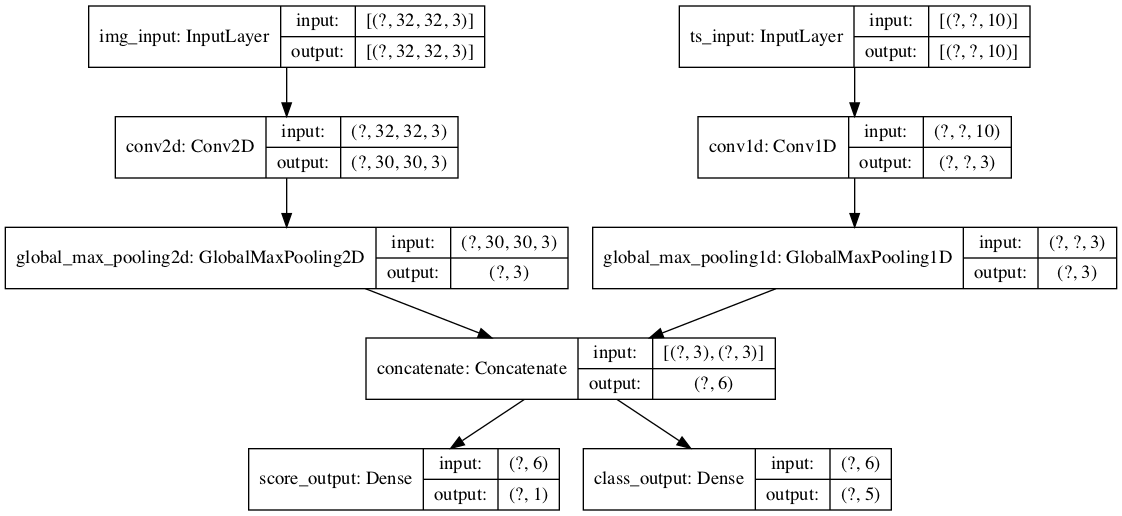

In [58]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [59]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [keras.metrics.MeanAbsolutePercentageError(),
         keras.metrics.MeanAbsoluteError()],
        [keras.metrics.CategoricalAccuracy()],
    ]
)

- If we only passed a single loss function to the model, the same loss function would be applied to every output (which is not appropriate here).
- Likewise for metrics.

- Since we gave names to our output layers, we could also specify per-output losses and metrics via a dictionary.

In [60]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy()
    },
    
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError()
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()]
    }
)

- It's possible to give different weights to different output-specific losses.
    - For instance, one might wish to privilege the "score" loss in our example, by giving to 2x the importance of the class loss), using the `loss_weights` argument.

In [61]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy()
    },
    
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError()
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()]
    },
    
    loss_weights={"score_output": 2.0, "class_output": 1.0}
)

- You could also choose not to compute a loss for certain outputs, if these outputs meant for prediction but not for training.

In [62]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss=[None, keras.losses.CategoricalCrossentropy()])

In [63]:
# Or using the dictionary version

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss={"class_output": keras.losses.CategoricalCrossentropy()})

- Passing data to a multi-input or multi-output model in `fit()` works in a similar way as specifying a loss function in `compile()`.
    - You can pass lists of NumPy arrays (with 1:1 mapping to the outputs that receive a loss function) or dicts mapping output names to NumPy arrays.

In [64]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

In [65]:
# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))

score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

In [66]:
# Fit on lists
model.fit([img_data, ts_data],
         [score_targets, class_targets],
         batch_size=32, epochs=1)

Train on 100 samples
100/100 [==============================] - 1s 12ms/sample - loss: 5.9598 - score_output_loss: 0.5238 - class_output_loss: 5.3261


In [67]:
# Alternatively, we can fit on dictionary
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1
)

Train on 100 samples
100/100 [==============================] - 0s 751us/sample - loss: 5.3934 - score_output_loss: 0.4274 - class_output_loss: 5.0158


- Here is the `Dataset` use case.
    - Similar to what we did for NumPy arrays, the `Dataset` should return a tuple of dictionaries.

In [68]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets}
    )
)

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

In [69]:
model.fit(train_dataset, epochs=1)

2/2 [==============================] - 1s 513ms/step - loss: 5.1327 - score_output_loss: 0.2306 - class_output_loss: 4.9020


# Using callbacks
- Callbacks in Keras are objects that are called at different point during training (at the start of an epoch, at the end of a batch, at the end of an epoch, etc.) and which can be used to implement behaviors such as:
    - Doing validation at different points during training (beyond the built-in per-epoch validation)
    - Checkpointing the model at regular intervals or when it exceeds a certain accuracy threshold
    - Changing the learning rate of the model when training seems to be plateauing
    - Doing fine-tuning of the top layers when training seems to be plateauing
    - Sending email or instant message notifications when training ends or where a certain performance threshold is exceeded
    - Etc.
- Callbacks can be passed as a list to your call to `fit()`.

In [70]:
model = get_compiled_model()

In [71]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', # stop training when val_loss is no longer improving
        min_delta = 1e-2, # "no longer improving" defined as "no better than 1e-2 less"
        patience=2,
        verbose=1
    )
]

In [72]:
model.fit(X_train, y_train, epochs=20, batch_size=64, 
          callbacks=callbacks, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 3s 87us/sample - loss: 0.3826 - sparse_categorical_accuracy: 0.8927 - val_loss: 0.2600 - val_sparse_categorical_accuracy: 0.9187
Epoch 2/20
40000/40000 [==============================] - 3s 76us/sample - loss: 0.1792 - sparse_categorical_accuracy: 0.9466 - val_loss: 0.1793 - val_sparse_categorical_accuracy: 0.9458
Epoch 3/20
40000/40000 [==============================] - 3s 78us/sample - loss: 0.1284 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.1601 - val_sparse_categorical_accuracy: 0.9495
Epoch 4/20
40000/40000 [==============================] - 3s 81us/sample - loss: 0.1011 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.1360 - val_sparse_categorical_accuracy: 0.9591
Epoch 5/20
40000/40000 [==============================] - 3s 82us/sample - loss: 0.0839 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.1330 - val_sparse_categorical_accuracy: 0.9612
Epoch 6/20
4000

## Many built-in callbacks are available
- `ModelCheckpoint`: Periodically save the model
- `EarlyStopping`: Stop training when training is no longer improving the validation metrics
- `TensorBoard`: Periodically write model logs that can be visualized in `TensorBoard`
- `CSVLogger`: Streams loss and metrics data to a CSV file

## Writing your own callback
- You can create a custom callback by extending the base class `keras.callbacks.Callback`.
- A callback has access to its associated model through the class property `self.model`.
- Here's a simple example saving a list of per-batch loss values during training.

In [73]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
        
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

## Checkpointing models
- When you're training model on relatively large datasets, it's crucial to save checkpoints of your model at frequent intervals.
- The easiest way to achieve this is with the `ModelCheckpoint` callback.

In [74]:
model = get_compiled_model()

In [75]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )
]

In [76]:
# model.fit(X_train, y_train, epochs=2, batch_size=64, 
#           callbacks=callbacks, validation_split=0.2)

- The `ModelCheckpoint` callback can be used to implement fault-tolerance: the ability to restart training from the last saved state of the model in case training gets randomly interrupted.
- Here is a basic example.

In [77]:
# import os

# # Prepare a directory to store all the checkpoints
# checkpoint_dir = "./ckpt"
# if not os.path.existsi(checkpoint_dir):
#     os.makedirs(checkpoint_dir)
    
# def make_or_restore_model():
#     # Either restore the latest model, or create a fresh one if there is no checkpoint available
#     checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
#     if checkpoints:
#         latest_checkpoint = max(checkpoints, key=os.path.getctime)
#         print("Restoring from", latest_checkpoint)
#         return keras.models.load_model(latest_checkpoint)
#     print("Creating a new model")
#     return get_compiled_model()

# model = make_or_restore_model()

# callbacks = [
#     # This callback saves a SavedModel every 100 batches.
#     # We include the training loss in the saved model name.
#     keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
#     )
# ]

# model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

# Using learning rate schedules
- A common pattern when training deep learning models is to gradually reduce the learning as training progresses. 
    - This is generally known as "learning rate decay".
- The learning decay schedule could be static (fixed in advance, as a function of the current epoch or the current batch index), or dynamic (responding to the current behavior of the model, in particular the validation loss).

## Passing a schedule to an optimizer
- You can easily use a static learning rate decay schedule by passing a schedule object as the `learning_rate` argument in the optimizer.

In [78]:
initial_learning_rate = 0.1

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

- Several built-in schedules are available.
    - `ExponentialDecay`
    - `PiecewiseConstantDecay`
    - `PolynomialDecay`
    - `InverseTimeDecay`

## Using callbacks to implement a dynamic learning rate schedule
- A dynamic learning rate schedule (for instance, decreasing the learning rate when the validation loss is no longer improving) cannot be achieved with these schedule objects since the optimizer does not have access to validation metrics.
- However, callbacks do have access to all metrics, including validation metrics! 
    - You can thus achieve this pattern by using a callback that modifies the current learning rate on the optimizer. 
    - In fact, this is even built-in as the `ReduceLROnPlateau` callback.